In [1]:
def denormalize(value, max_value, min_value):
    """
    将归一化到[-1, 1]区间的数据还原到原始数据范围。

    参数:
    value (float or numpy.ndarray): 归一化后的值，取值范围在[-1, 1]之间，可以是单个数值或者是一个数组形式的数据。
    max_value (float): 原始数据的最大值。
    min_value (float): 原始数据的最小值。

    返回:
    float or numpy.ndarray: 还原后的原始数据值，如果输入的是单个数值则返回单个数值，如果输入是数组则返回对应维度的数组。
    """
    return (value + 1) / 2 * (max_value - min_value) + min_value
    

In [2]:
def denormalize_data(a, b):
    for i in range(a.shape[1]):
        x_min = np.nanmin(a[:,i,:,:])
        x_max = np.nanmax(a[:,i,:,:])
        b[:,i,:,:]=denormalize(b[:,i,:,:], x_max,x_min )
    return b

In [3]:
import numpy as np
ground_truths=np.load("/home/hy4080/met_waves/data/wave_filed.npy")
predictions=np.load("/home/hy4080/met_waves/data/generated_wave_fields.npy")
predictions=denormalize_data(ground_truths,predictions)

In [4]:
import numpy as np

# 找出array1中值为0的位置索引，返回的是一个元组，每个元素对应相应维度的索引数组
zero_indices = np.where(ground_truths == 0)

# 根据索引将array2中对应位置的元素变为0
predictions[zero_indices] = 0
# predictions_np = predictions[0:2000,:,:,:]
# ground_truth_np = ground_truths[0:2000,:,:,:]
# 
# print(predictions_np[0,0,12,:],ground_truth_np[0,0,12,:])


In [5]:
import numpy as np

def restore_wave_directions_and_replace(predictions):
    """
    从预测数据中恢复波方向 (dirm)，
    其中 cos(dirm) 存储在通道 2，sin(dirm) 存储在通道 3，
    并将恢复的波方向作为第 2 维度（通道）插入，替代原来的第 2 和第 3 通道。

    参数：
    - predictions: 预测数据 (T, C, W, H)，
                   其中第 2 通道是 cos(dirm)，第 3 通道是 sin(dirm)

    返回：
    - 恢复的波方向作为第 2 维度插入后的数据，删除原来的第 2 和第 3 通道
    """
    # 提取 cos_dirm 和 sin_dirm
    cos_dirm = predictions[:, 2, :, :]  # 第 2 通道是 cos(dirm)
    sin_dirm = predictions[:, 3, :, :]  # 第 3 通道是 sin(dirm)
    
    # 使用 arctan2 恢复弧度
    dirm_rad = np.arctan2(sin_dirm, cos_dirm)
    
    # 将弧度转换为度数，并确保在 [0, 360) 范围内
    dirm = np.degrees(dirm_rad) % 360
    
    # 删除原数据中的第 2 和第 3 通道（cos_dirm 和 sin_dirm）
    predictions_reduced = np.delete(predictions, [2, 3], axis=1)  # 删除通道2和3

    # 将恢复的 dirm 插入为新的通道
    dirm_expanded = dirm[:, np.newaxis, :, :]  # 扩展维度为 (T, 1, W, H)

    # 将恢复的 dirm 插入到数据中，形成新的 (T, C-1, W, H)
    predictions_with_dirm = np.concatenate([predictions_reduced, dirm_expanded], axis=1)

    return predictions_with_dirm

In [6]:
def average_by_groups(data, group_size):
    """
    对 NumPy 数据按第一维度每 group_size 个元素分组，计算分组内的平均值。

    参数：
        data (np.ndarray): 输入数据，形状为 (N, C, H, W)。
        group_size (int): 每组的大小。

    返回：
        np.ndarray: 计算分组平均值后的数据，形状为 (N // group_size, C, H, W)。
    """
    if data.shape[0] % group_size != 0:
        raise ValueError(f"第一维度长度 {data.shape[0]} 不是 group_size {group_size} 的整数倍，无法分组。")

    # 计算新的形状
    grouped_shape = (data.shape[0] // group_size, group_size, *data.shape[1:])

    # 重塑数据并计算平均值
    grouped_data = data.reshape(grouped_shape)
    averaged_data = grouped_data.mean(axis=1)  # 在第二维度上求平均值

    return averaged_data


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_rmse_per_time(predictions, ground_truths, channel):
    """
    计算每个时间点的 RMSE（每个点在时间维度上计算）。

    参数：
    - predictions: 4D NumPy 数组，形状为 [时间, 通道, X, Y]
    - ground_truths: 4D NumPy 数组，形状为 [时间, 通道, X, Y]
    - channel: int，指定通道索引

    返回：
    - time_rmse: 一维数组，表示每个时间点的 RMSE 值
    """
    # 提取当前通道数据
    pred = predictions[:, channel, :]
    truth = ground_truths[:, channel, :, :]

    # 将 0 替换为 NaN，避免无效数据对计算的影响
    pred[pred == 0] = np.nan
    truth[truth == 0] = np.nan

    # 初始化用于存储每个时间点的 RMSE
    time_rmse = []
    # 对每个时间点计算 RMSE
    for t in range(pred.shape[0]):
        pred_c = pred[t, :, :]
        truth_c = truth[t,:, :]

        # 对于方向（dirm1, dirm2），需要计算周期差异 (0-360) 之间的最小差异
        if channel == 2 :  # dirm1 或 dirm2
            diff = np.minimum(np.abs(pred_c - truth_c), 360 - np.abs(pred_c - truth_c))  # 计算周期最小差异
        else:
            diff = np.abs(pred_c - truth_c)  # 对于其他通道，直接计算差异
        
        squared_error = diff ** 2  # 计算平方误差

        total_valid_points = np.sum(~np.isnan(squared_error))  # 非 NaN 点数

        # 计算 RMSE 并归一化
        if total_valid_points > 0:
            mse = np.nansum(squared_error) / total_valid_points
            rmse = np.sqrt(mse)
        else:
            rmse = np.nan
        
        time_rmse.append(rmse)

    return np.array(time_rmse)

def plot_rmse_over_time(predictions, ground_truths):

     # 预定义颜色列表
    colors = ['b', 'g', 'r']  # 蓝色、绿色、红色、青色

    # 创建一个 4 行 1 列的子图，绘制 4 个通道的 RMSE
    fig, axes = plt.subplots(3, 1, figsize=(12, 8))  # 调整高度，确保上下排列
    channel_name=['Hs','Tm','dirm']
    for channel in range(3):  # 对每个通道绘制
        # 计算每个时间点的 RMSE
        time_rmse = calculate_rmse_per_time(predictions, ground_truths, channel)

        # 绘制 RMSE 折线图
        axes[channel].plot(time_rmse, label=f"RMSE - Channel {channel_name[channel]}", color=colors[channel])
        axes[channel].set_title(f"RMSE Over Time - Channel {channel} ({channel_name[channel]})", fontsize=14)
        axes[channel].set_xlabel("Time Step")
        axes[channel].set_ylabel("RMSE")
        axes[channel].legend()
        axes[channel].grid(True)
        # 设置 y 轴从 0 开始
        axes[channel].set_ylim(0, np.max(time_rmse) + 0.1)  # +0.1 给 y 轴上限留点空白
    plt.tight_layout()  # 自动调整布局，防止子图重叠
    plt.show()

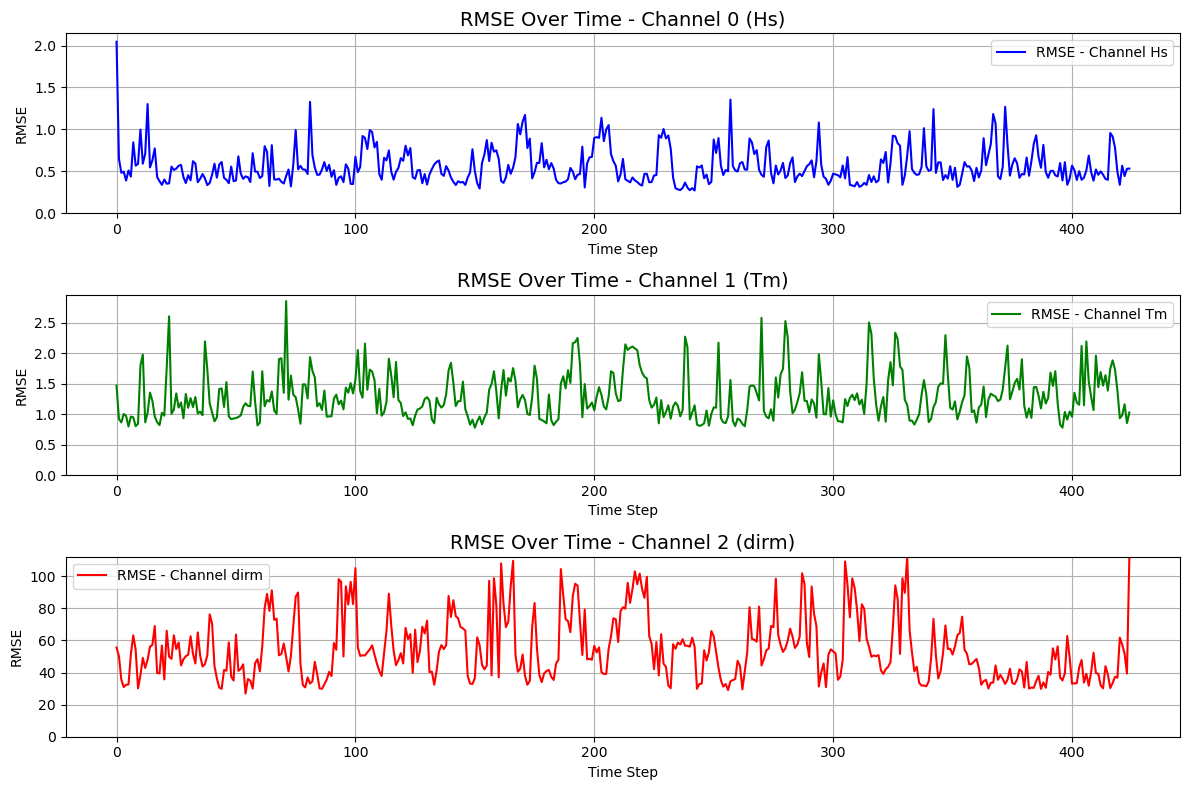

In [8]:
predictions_ori=restore_wave_directions_and_replace(predictions)
ground_truths_ori=restore_wave_directions_and_replace(ground_truths)
predictions_day=average_by_groups(predictions_ori, 24)
ground_truths_day=average_by_groups(ground_truths_ori, 24)
plot_rmse_over_time(predictions_day, ground_truths_day)

In [9]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_hs(predictions, ground_truths, feature_name, channel_idx=0):
    """
    绘制预测和真实值的均值图以及它们的差异图。

    参数：
    - predictions: 4D NumPy 数组，形状为 [时间, 通道, X, Y]
    - ground_truths: 4D NumPy 数组，形状为 [时间, 通道, X, Y]
    - feature_name: 字符串，表示特征的名称
    - channel_idx: 整数，表示通道索引（默认值为0）

    输出：
    - 生成预测、真实值均值图以及差异图
    """
    # 提取指定通道的 hs 数据
    hs_predictions = predictions[:, channel_idx, :, :]
    hs_ground_truths = ground_truths[:, channel_idx, :, :]

    # 将 0 替换为 NaN
    hs_predictions[hs_predictions == 0] = np.nan
    hs_ground_truths[hs_ground_truths == 0] = np.nan

     # 定义安全的均值计算函数
    def safe_nanmean(data, axis):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            return np.nanmean(data, axis=axis)

    # 计算均值
    hs_mean_predictions = safe_nanmean(hs_predictions, axis=0)
    hs_mean_ground_truths = safe_nanmean(hs_ground_truths, axis=0)

    # 计算差异（取绝对值）
    hs_mean_difference = np.abs(hs_mean_predictions - hs_mean_ground_truths)

    # 绘制图像
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))

    # 左图：预测均值
    im1 = axes[0].imshow(hs_mean_predictions, cmap='viridis', origin='lower', aspect='auto')
    axes[0].set_title(f"Mean {feature_name} - Predictions", fontsize=14)
    axes[0].set_xlabel("Grid X")
    axes[0].set_ylabel("Grid Y")
    fig.colorbar(im1, ax=axes[0], label=f"Mean {feature_name}")

    # 中图：真实值均值
    im2 = axes[1].imshow(hs_mean_ground_truths, cmap='viridis', origin='lower', aspect='auto')
    axes[1].set_title(f"Mean {feature_name} - Ground Truths", fontsize=14)
    axes[1].set_xlabel("Grid X")
    axes[1].set_ylabel("Grid Y")
    fig.colorbar(im2, ax=axes[1], label=f"Mean {feature_name}")

    # 右图：差异图
    im3 = axes[2].imshow(hs_mean_difference, cmap='viridis', origin='lower', aspect='auto')
    axes[2].set_title(f"Difference in {feature_name}", fontsize=14)
    axes[2].set_xlabel("Grid X")
    axes[2].set_ylabel("Grid Y")
    fig.colorbar(im3, ax=axes[2], label=f"Absolute Difference ({feature_name})")

    # 显示图像
    plt.tight_layout()
    plt.show()


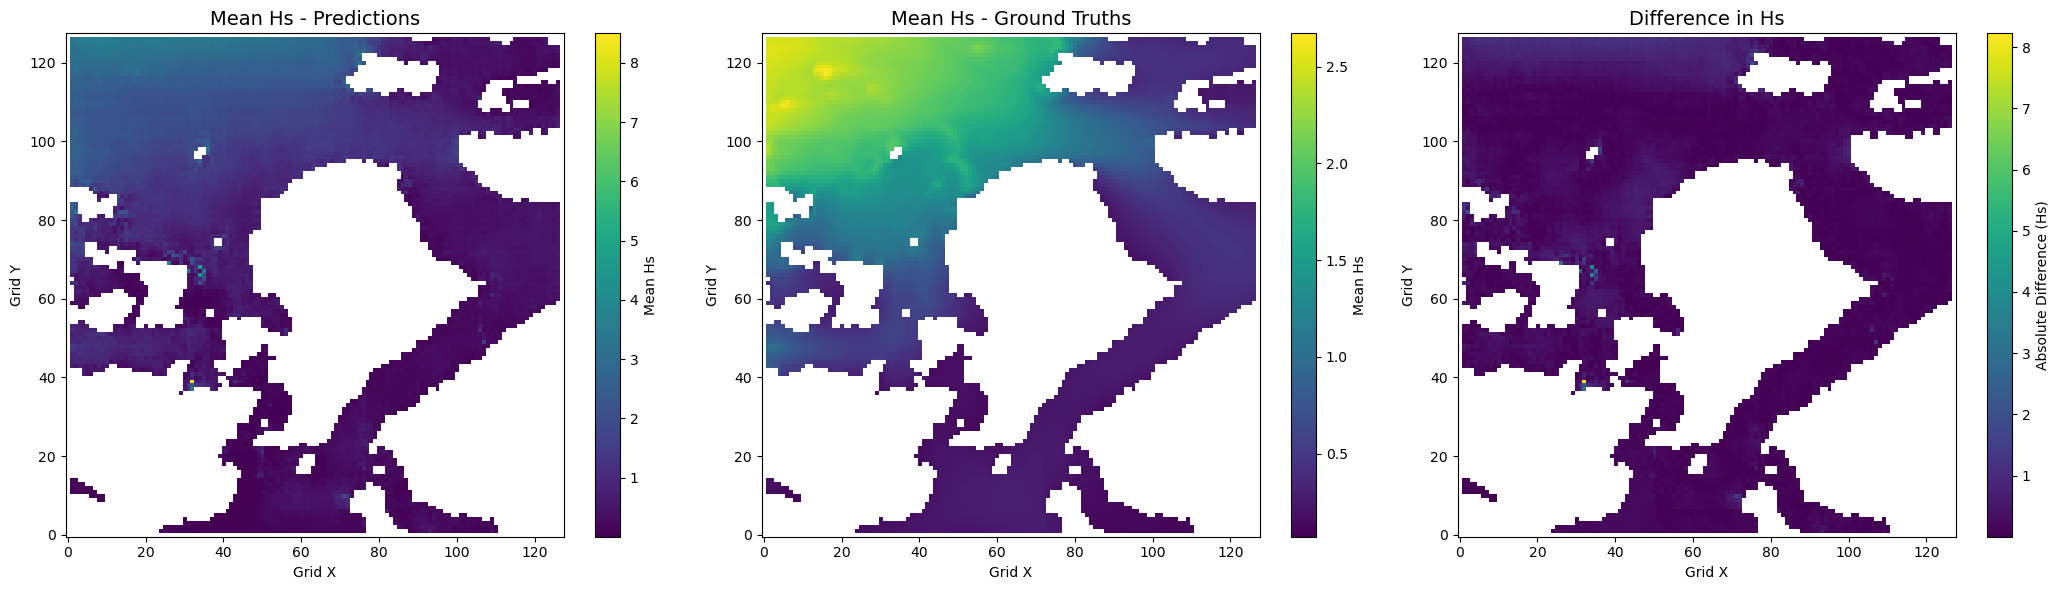

In [10]:
plot_mean_hs(predictions, ground_truths, feature_name="Hs", channel_idx=0)

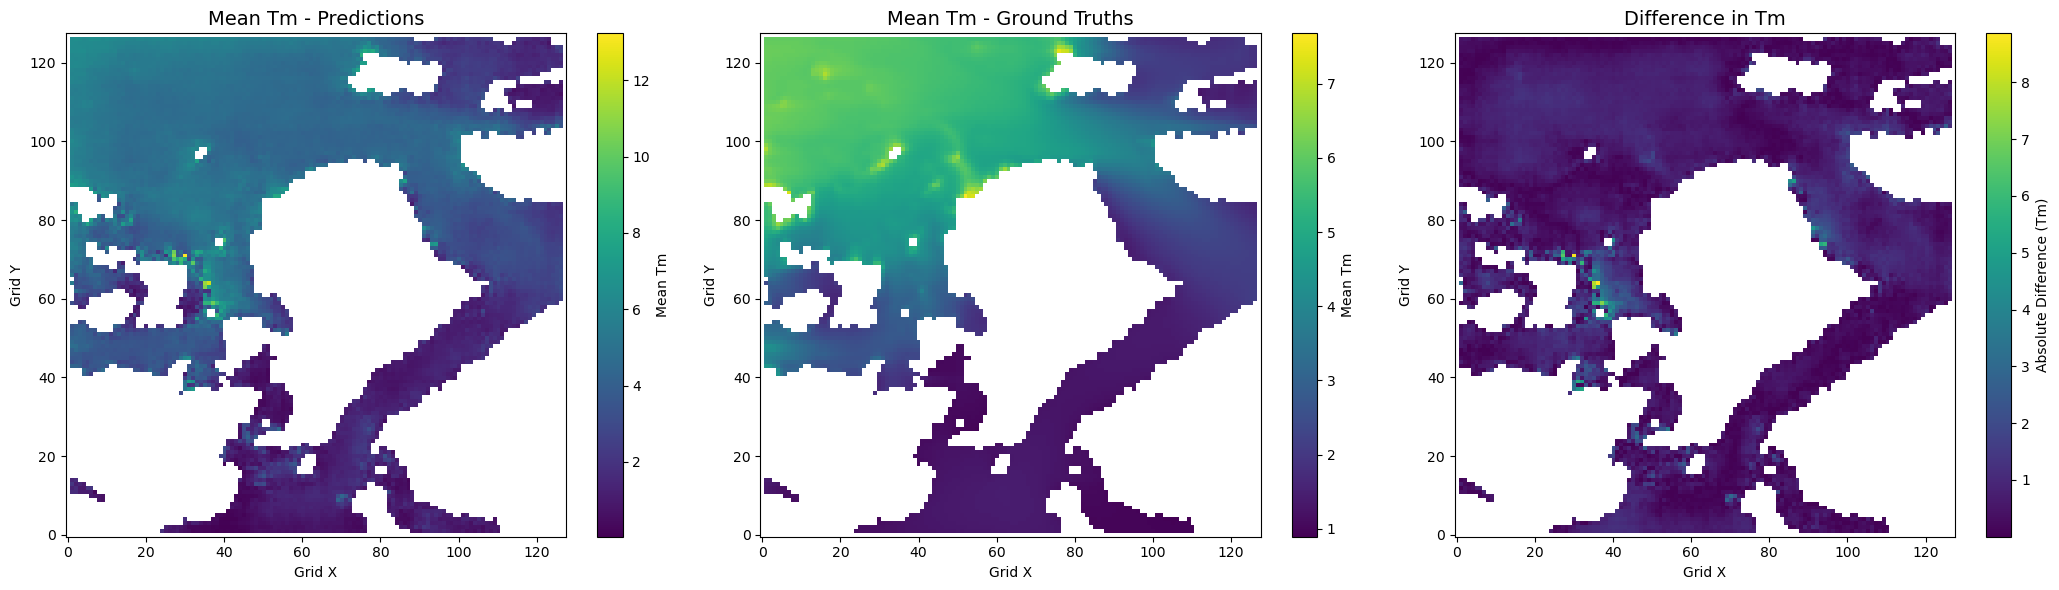

In [11]:
plot_mean_hs(predictions, ground_truths, feature_name="Tm", channel_idx=1)

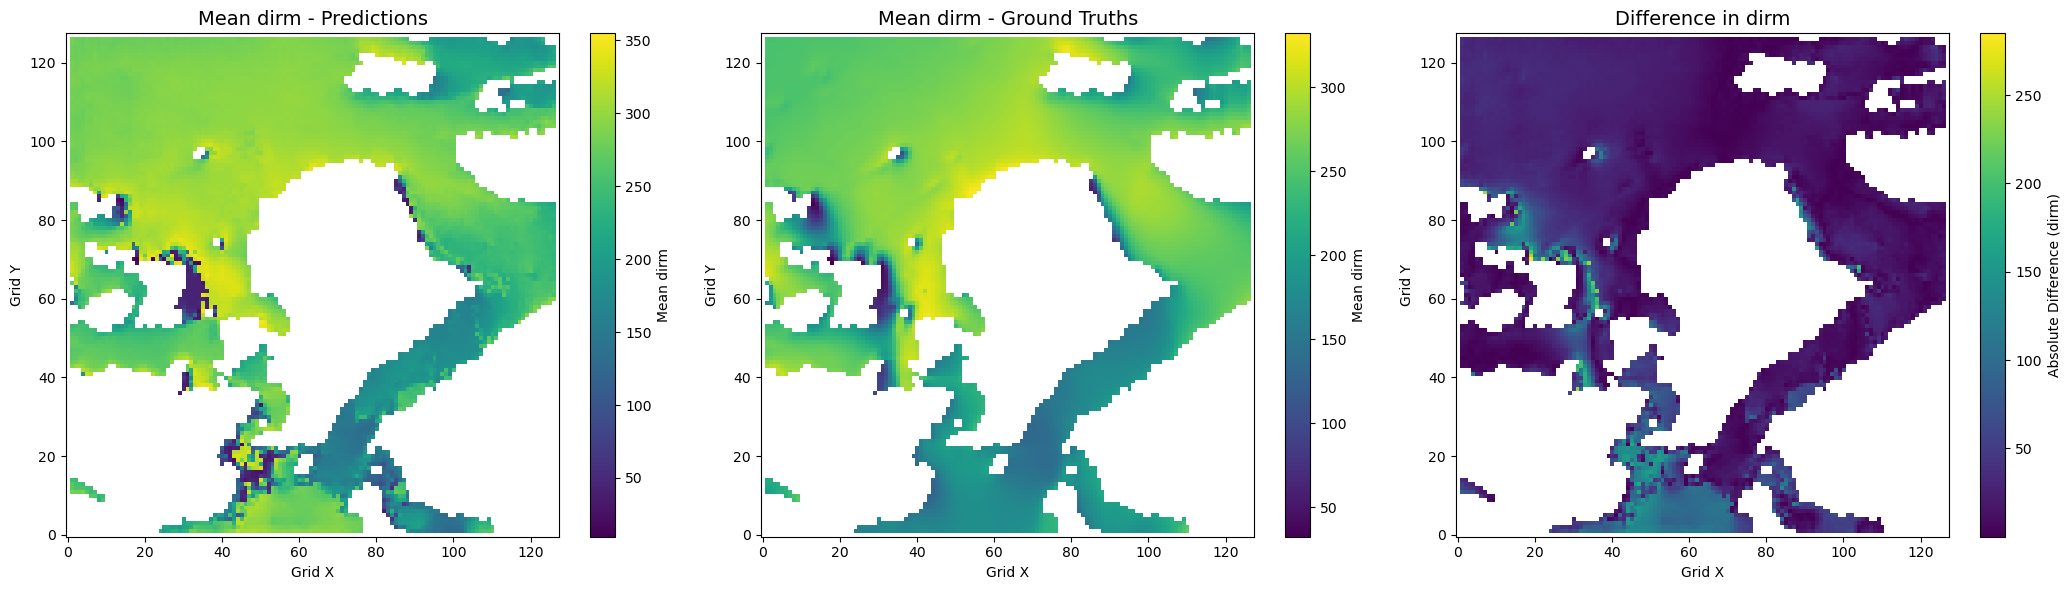

In [12]:
plot_mean_hs(predictions_day, ground_truths_day, feature_name="dirm", channel_idx=2)

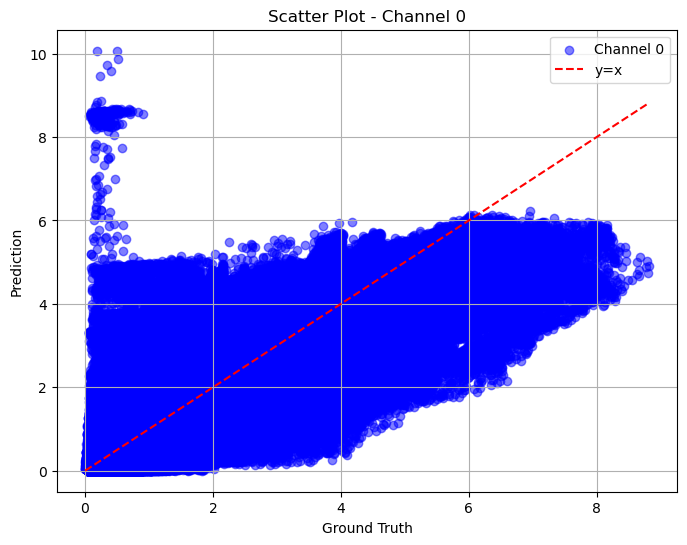

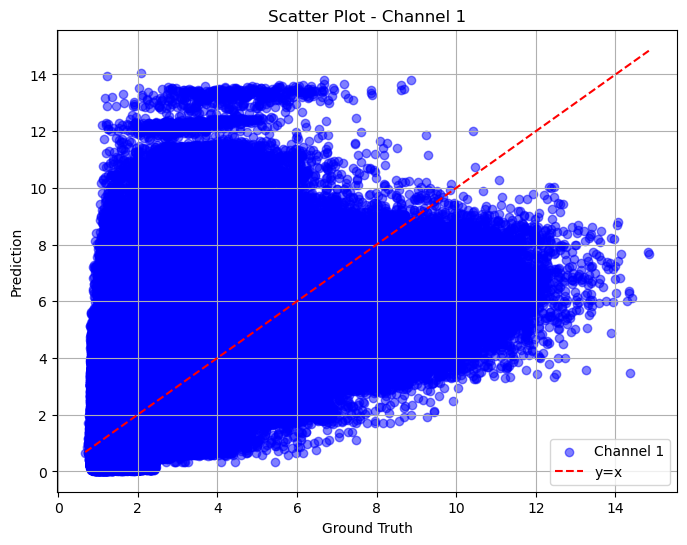

/home/hy4080/anaconda3/envs/pytorch-gpu/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


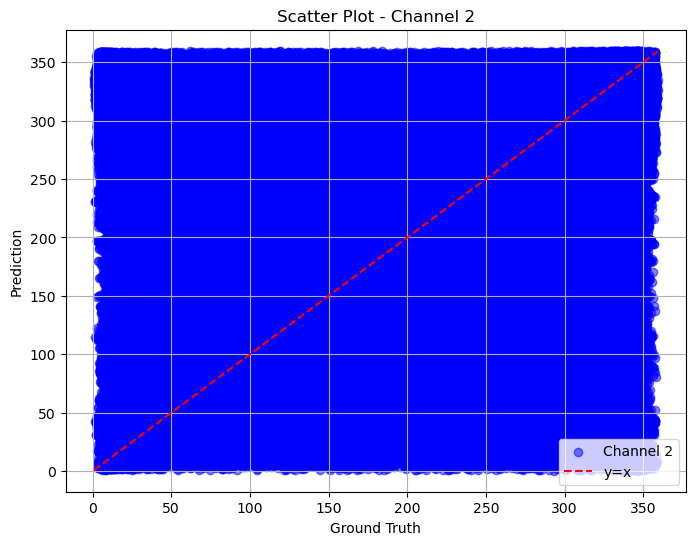

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_scatter_per_channel(predictions, ground_truths, channel):
    """
    为每个通道绘制预测值和真实值的散点图。
    参数：
    - predictions: 预测值，形状为 (T, C, W, H)
    - ground_truths: 真实值，形状为 (T, C, W, H)
    - channel: 当前要处理的通道索引
    """
    # 获取当前通道的预测值和真实值（按时间维度展开）
    pred_values = predictions[:, channel, :, :].flatten()
    truth_values = ground_truths[:, channel, :, :].flatten()

    # 去除 NaN 值
    mask = ~np.isnan(pred_values) & ~np.isnan(truth_values)
    pred_values = pred_values[mask]
    truth_values = truth_values[mask]

    # 绘制散点图
    plt.figure(figsize=(8, 6))
    plt.scatter(truth_values, pred_values, alpha=0.5, color='blue', label=f"Channel {channel}")
    plt.plot([np.min(truth_values), np.max(truth_values)], [np.min(truth_values), np.max(truth_values)], color='red', linestyle='--', label="y=x")
    plt.xlabel("Ground Truth")
    plt.ylabel("Prediction")
    plt.title(f"Scatter Plot - Channel {channel}")
    plt.legend()
    plt.grid(True)
    plt.show()

# 假设 predictions 和 ground_truths 是你已经获得的数据
channel_name = ['Hs', 'Tm', 'dirm']

# 为每个通道绘制散点图
for channel in range(3):
    plot_scatter_per_channel(predictions_day, ground_truths_day, channel)
